# Validation: Forecasting Held-Out Data

This notebook:

* loads a library defined model. 
* loads the data according to the data loader.
* holds-out the final few days of the data, and see's if they can be predicted. 

In [79]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [86]:
### Initial imports
import logging
import numpy as np
import pandas as pd
import pymc3 as pm
import theano.tensor as T
import matplotlib.pyplot as plt

logging.basicConfig(level=logging.INFO)
log = logging.getLogger(__name__)

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

from epimodel.pymc3_models.utils import geom_convolution
from epimodel.pymc3_models import cm_effect
from epimodel.pymc3_models.cm_effect.datapreprocessor import DataPreprocessor

%matplotlib inline

In [81]:
regions = ["PT", "IS", "HU", "HR", "BE", "NL", "DK", "DE", "AT", "CZ", "GE", "FR", "ES", "GB", "PL", "GR", "CH", "FI", "NO", "SE", "SI", "SK"]
features = ['Gatherings limited to', 'Business suspended', 'Schools and universities closed', 'General curfew',
       'Healthcare specialisation', 'Phone line',
       'Asymptomatic contact isolation']

data = cm_effect.loader.Loader('2020-02-15', '2020-04-05', Regions, Features)

# Probability of being in Confirmed cases X days after transmission, from 0
# Generated from Poisson dist., must sum to 1.0
DelayProb = np.array([0.00, 0.01, 0.02, 0.06, 0.10, 0.13, 0.15, 0.15, 0.13, 0.10, 0.07, 0.05, 0.03])
print(f"Delayprob sum={DelayProb.sum()}, E[DP]={np.sum(DelayProb*np.arange(len(DelayProb)))}")

INFO:epimodel.regions:Name index has 6 potential conflicts: ['american samoa', 'georgia', 'guam', 'northern mariana islands', 'puerto rico', 'united states minor outlying islands']


Delayprob sum=1.0, E[DP]=6.78


In [83]:
with cm_effect.models.CMModelV2(data) as model:
    model.build_all()

/Users/mrinank/Library/Caches/pypoetry/virtualenvs/epimodel-H-ywULmv-py3.7/lib/python3.7/site-packages/pymc3/model.py:1430: ImputationWarning: Data in Observed contains missing values and will be automatically imputed from the sampling distribution.
  warnings.warn(impute_message, ImputationWarning)
INFO:epimodel.pymc3_models.cm_effect.models:Checking model test point
INFO:epimodel.pymc3_models.cm_effect.models:
CMReduction_log__            12.45
BaseGrowthRate_log__         -1.61
RegionGrowthRate_log__        6.27
RegionScaleMult_log__       -20.22
DailyGrowth_log__          1248.05
InitialSize_log__           -70.87
Observed_missing              0.00
Observed                 -21899.64
Name: Log-probability of test_point, dtype: float64



In [89]:
model.run(100)

Only 100 samples in chain.
Auto-assigning NUTS sampler...
INFO:pymc3:Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
INFO:pymc3:Initializing NUTS using adapt_diag...


CMReduction_log__            12.45
BaseGrowthRate_log__         -1.61
RegionGrowthRate_log__        6.27
RegionScaleMult_log__       -20.22
DailyGrowth_log__          1248.05
InitialSize_log__           -70.87
Observed_missing              0.00
Observed                 -21899.64
Name: Log-probability of test_point, dtype: float64


Multiprocess sampling (2 chains in 2 jobs)
INFO:pymc3:Multiprocess sampling (2 chains in 2 jobs)
NUTS: [Observed_missing, InitialSize, DailyGrowth, RegionScaleMult, RegionGrowthRate, BaseGrowthRate, CMReduction]
INFO:pymc3:NUTS: [Observed_missing, InitialSize, DailyGrowth, RegionScaleMult, RegionGrowthRate, BaseGrowthRate, CMReduction]
Sampling 2 chains, 0 divergences:  17%|█▋        | 206/1200 [00:02<00:14, 69.29draws/s] 


RuntimeError: Chain 0 failed.

Process worker_chain_1:
Traceback (most recent call last):
  File "/Users/mrinank/Library/Caches/pypoetry/virtualenvs/epimodel-H-ywULmv-py3.7/lib/python3.7/site-packages/pymc3/parallel_sampling.py", line 110, in run
    self._start_loop()
  File "/Users/mrinank/Library/Caches/pypoetry/virtualenvs/epimodel-H-ywULmv-py3.7/lib/python3.7/site-packages/pymc3/parallel_sampling.py", line 160, in _start_loop
    point, stats = self._compute_point()
  File "/Users/mrinank/Library/Caches/pypoetry/virtualenvs/epimodel-H-ywULmv-py3.7/lib/python3.7/site-packages/pymc3/parallel_sampling.py", line 191, in _compute_point
    point, stats = self._step_method.step(self._point)
  File "/Users/mrinank/Library/Caches/pypoetry/virtualenvs/epimodel-H-ywULmv-py3.7/lib/python3.7/site-packages/pymc3/step_methods/arraystep.py", line 247, in step
    apoint, stats = self.astep(array)
  File "/Users/mrinank/Library/Caches/pypoetry/virtualenvs/epimodel-H-ywULmv-py3.7/lib/python3.7/site-packages/pymc3/step_methods/h


During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/Cellar/python/3.7.4_1/Frameworks/Python.framework/Versions/3.7/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/Users/mrinank/Library/Caches/pypoetry/virtualenvs/epimodel-H-ywULmv-py3.7/lib/python3.7/site-packages/pymc3/parallel_sampling.py", line 117, in run
    self._msg_pipe.send(("error", None, e))
  File "/usr/local/Cellar/python/3.7.4_1/Frameworks/Python.framework/Versions/3.7/lib/python3.7/multiprocessing/connection.py", line 206, in send
    self._send_bytes(_ForkingPickler.dumps(obj))
  File "/usr/local/Cellar/python/3.7.4_1/Frameworks/Python.framework/Versions/3.7/lib/python3.7/multiprocessing/connection.py", line 398, in _send_bytes
    self._send(buf)
  File "/usr/local/Cellar/python/3.7.4_1/Frameworks/Python.framework/Versions/3.7/lib/python3.7/multiprocessing/connection.py", line 368, in _send
    n = write(s

INFO:epimodel.regions:Name index has 6 potential conflicts: ['american samoa', 'georgia', 'guam', 'northern mariana islands', 'puerto rico', 'united states minor outlying islands']
INFO:epimodel.pymc3_models.cm_effect.datapreprocessor:
Countermeasures                               min   .. mean  .. max
INFO:epimodel.pymc3_models.cm_effect.datapreprocessor: 0 Gatherings limited to                      0.000 .. 0.177 .. 0.982
INFO:epimodel.pymc3_models.cm_effect.datapreprocessor: 1 Business suspended                         0.000 .. 0.273 .. 1.000
INFO:epimodel.pymc3_models.cm_effect.datapreprocessor: 2 Schools and universities closed            0.000 .. 0.361 .. 1.000
INFO:epimodel.pymc3_models.cm_effect.datapreprocessor: 3 General curfew                             0.000 .. 0.167 .. 1.000
INFO:epimodel.pymc3_models.cm_effect.datapreprocessor: 4 Healthcare specialisation                  0.000 .. 0.020 .. 0.429
INFO:epimodel.pymc3_models.cm_effect.datapreprocessor: 5 Phone line         

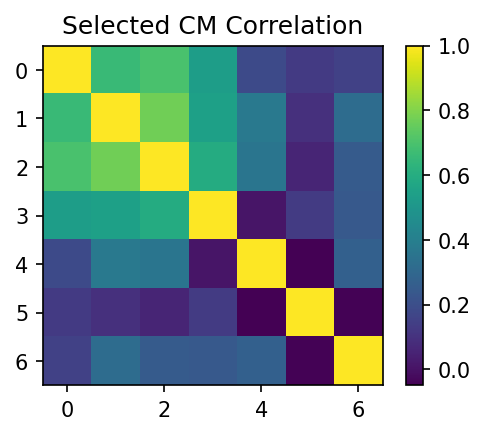

INFO:epimodel.pymc3_models.cm_effect.datapreprocessor:Data Preprocessing Complete using:

{
    "start_date": "2020-2-10",
    "end_date": "2020-04-05",
    "min_final_num_active_cases": 100,
    "min_num_active_mask": 10,
    "min_num_confirmed_mask": 10
}


Delayprob sum=1.0, E[DP]=6.78


In [87]:
regions = ["PT", "IS", "HU", "HR", "BE", "NL", "DK", "DE", "AT", "CZ", "GE", "FR", "ES", "GB", "PL", "GR", "CH", "FI", "NO", "SE", "SI", "SK"]
features = ['Gatherings limited to', 'Business suspended', 'Schools and universities closed', 'General curfew',
       'Healthcare specialisation', 'Phone line', 'Asymptomatic contact isolation']

dp = DataPreprocessor()
data = dp.preprocess_data("../../data", regions, features)

# Probability of being in Confirmed cases X days after transmission, from 0
# Generated from Poisson dist., must sum to 1.0
DelayProb = np.array([0.00, 0.01, 0.02, 0.06, 0.10, 0.13, 0.15, 0.15, 0.13, 0.10, 0.07, 0.05, 0.03])
print(f"Delayprob sum={DelayProb.sum()}, E[DP]={np.sum(DelayProb*np.arange(len(DelayProb)))}")

In [90]:
with cm_effect.models.CMModelV2(data) as model2:
    model2.build_all()

INFO:epimodel.pymc3_models.cm_effect.models:Checking model test point
INFO:epimodel.pymc3_models.cm_effect.models:
CMReduction_log__             9.69
BaseGrowthRate_log__         -1.61
RegionGrowthRate_log__        6.27
RegionScaleMult_log__       -20.22
DailyGrowth_log__          1400.25
InitialSize_log__           -70.87
Observed_missing              0.00
Observed                 -15098.43
Name: Log-probability of test_point, dtype: float64



In [92]:
model2.run(100)

Only 100 samples in chain.
Auto-assigning NUTS sampler...
INFO:pymc3:Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
INFO:pymc3:Initializing NUTS using adapt_diag...


CMReduction_log__             9.69
BaseGrowthRate_log__         -1.61
RegionGrowthRate_log__        6.27
RegionScaleMult_log__       -20.22
DailyGrowth_log__          1400.25
InitialSize_log__           -70.87
Observed_missing              0.00
Observed                 -15098.43
Name: Log-probability of test_point, dtype: float64


Multiprocess sampling (2 chains in 2 jobs)
INFO:pymc3:Multiprocess sampling (2 chains in 2 jobs)
NUTS: [Observed_missing, InitialSize, DailyGrowth, RegionScaleMult, RegionGrowthRate, BaseGrowthRate, CMReduction]
INFO:pymc3:NUTS: [Observed_missing, InitialSize, DailyGrowth, RegionScaleMult, RegionGrowthRate, BaseGrowthRate, CMReduction]
Sampling 2 chains, 10 divergences: 100%|██████████| 1200/1200 [02:08<00:00,  9.34draws/s]
There were 6 divergences after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc3:There were 6 divergences after tuning. Increase `target_accept` or reparameterize.
There were 4 divergences after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc3:There were 4 divergences after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
ERROR:pymc3:The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The number of effective sa

In [ ]:
_ = model2.plot_traces()

Conclusions:
* there seems to be some issue with the loader class, I reverted to the DataPreprocessor Class that I wrote. 
* I also had issues when including "'Phone line', 'Asymptomatic contact isolation'", yet to test whether this is a bug in the loader class or elsewhere.